In [1]:
import random
from PIL import Image
import numpy as np
import cv2
import Augmentor
import matplotlib.pyplot as plt
from IPython.display import display
import glob
import os,sys
from sklearn.preprocessing import LabelBinarizer

In [2]:
train_data = np.load("/Users/sawaki/skill-up-ai/train_data.npy")
train_label = np.load("/Users/sawaki/skill-up-ai/train_label.npy")
train_data = train_data.astype('float32')
train_data = train_data / train_data.max()

In [27]:
train_data.shape

(3000, 1, 28, 28)

In [28]:
train_label

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


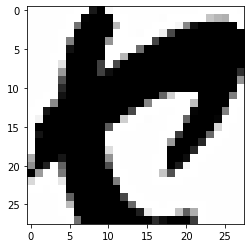

<class 'numpy.ndarray'>
(1, 28, 28)


In [29]:
ind = 0
num = np.where(train_label[ind])[0][0]
img = train_data[ind]
label = train_label[ind]    
print(label)
plt.imshow(img[0,:,:], cmap='gray')
plt.show()

print(type(img))
print(img.shape)

# 以下ではnumpyを使ってData Augmentationを行う

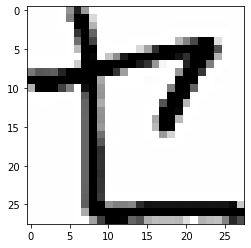

In [87]:
img = train_data[0:3]
img.shape
plt.imshow(img[2][0], cmap='gray')

(1, 56, 56)


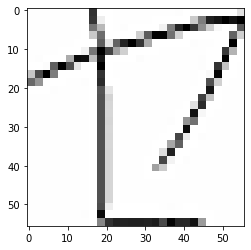

In [88]:
#画像を2倍に拡大
img = train_data[3]
img2 = img.repeat(2, axis=1).repeat(2, axis=2)
print(img2.shape)
plt.imshow(img2[0,:,:], cmap='gray')

In [175]:
#affine変換によるリサイズ用def文
def resize_affine(image,ratio):
    #引数に倍率とイメージ（ndarray）を渡す
    img = image
    #print(img.shape)
    img = img.transpose(1,2,0)
    #print(img.shape)
    h, w = img.shape[:2]
    #print('input size : {0}x{1}'.format(h, w))

    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src * ratio
    affine = cv2.getAffineTransform(src, dest)
    #print('output size : {0}x{1}'.format(int(float(w)*ratio), int(float(h)*ratio)))

    
    img2 = cv2.warpAffine(img, affine, (int(float(w)*ratio), int(float(h)*ratio)), cv2.INTER_LANCZOS4)
    #print(img2.shape)

    # 1次元目が消えちゃうので追加して元のshape (1, h, w)に戻す
    img3 = img2[np.newaxis, :, :]
    print(img3.shape)
    return img3

(1, 28, 28)
(28, 28, 1)
input size : 28x28
output size : 25x25
(25, 25)
(1, 25, 25)


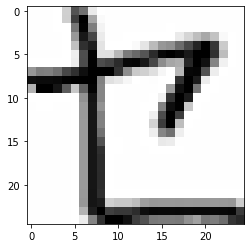

In [96]:
img = train_data[2]
temp = resize_affine(img, 0.9)
plt.imshow(temp[0,:,:], cmap='gray')

(1, 28, 28)
(28, 28, 1)
input size : 28x28
output size : 20x20
(20, 20)
(1, 20, 20)
(20, 20)
(1, 28, 28)


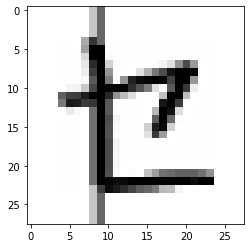

In [174]:
#paddingして28x28に戻す
#(scale,pad)=(0.93,1),(0.86,2),(0.79,3)(0.72, 4)

img = train_data[10]
img2 = resize_affine(img, 0.72)
print(img2[0].shape)
img3 = np.pad(img2[0], 4, "maximum")
plt.imshow(img3, cmap='gray')
#消えた一次元目を追加
img4 = img3[np.newaxis, :, :]
print(img4.shape)

In [224]:
# 縮小　and Padding  (93%固定)
def reduction_padding(img):
    img2 = resize_affine(img, 0.93)
    #print(img2[0].shape)
    img3 = np.pad(img2[0], 1, "maximum")
    #plt.imshow(img3, cmap='gray')
    #消えた一次元目を追加
    img4 = img3[np.newaxis, :, :]

    return img4

# 縮小　and Padding  (93%, 86%, 79%, 72%) 
def reduction_padding_rand(img):
    red_scale, pad = 0, 0
    a = np.random.randint(1,5)
    print(a)
    if a == 1: red_scale, pad = 0.93, 1
    if a == 2: red_scale, pad = 0.86, 2
    if a == 3: red_scale, pad = 0.79, 3
    if a == 4: red_scale, pad = 0.72, 4

    img2 = resize_affine(img, red_scale)
    #print(img2[0].shape)
    img3 = np.pad(img2[0], pad, "maximum")
    #plt.imshow(img3, cmap='gray')
    #消えた一次元目を追加
    img4 = img3[np.newaxis, :, :]

    return img4

    

4
(1, 20, 20)


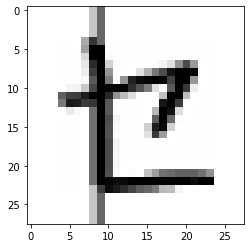

In [253]:
img = train_data[10]
img2 = reduction_padding_rand(img)
plt.imshow(img2[0], cmap='gray')

In [112]:
X = np.arange(9).reshape(3,3)
print(X)

X_pad = np.pad(X, 2) 
print(X_pad)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0]
 [0 0 3 4 5 0 0]
 [0 0 6 7 8 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [7]:
def random_crop(image, crop_size=(28, 28)):
    _, h, w = image.shape
    #print(h, w)

    # 0~(400-224)の間で画像のtop, leftを決める
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])

    # top, leftから画像のサイズである224を足して、bottomとrightを決める
    bottom = top + crop_size[0]
    right = left + crop_size[1]

    # 決めたtop, bottom, left, rightを使って画像を抜き出す
    image = image[:, top:bottom, left:right]
    return image

In [86]:
img = train_data[55]
img2 = random_crop(img)
plt.imshow(img2[0,:,:], cmap='gray')

ValueError: high <= 0

In [58]:
from scipy.ndimage.interpolation import rotate

def random_rotation(image, angle_range):
    _, h, w = image.shape
    #print(image.shape, h, w)
    angle = np.random.randint(*angle_range)
    #print(angle)

    image = np.squeeze(image)
    #print(image.shape)

    image = rotate(image, angle)
    #print(image.shape)
    
    # 1次元目が消えちゃうので追加して元のshape (1, h, w)に戻す
    image = image[np.newaxis, :, :]

    return image

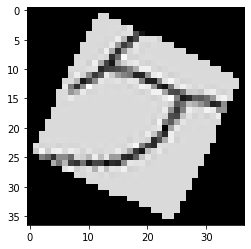

In [83]:
img = train_data[55]
img2 = random_rotation(img,(-30, 30))
plt.imshow(img2[0,:,:], cmap='gray')

In [45]:
def rotate_aug(images, angle_range=(-30, 30)):
    """
    input : images (num, 1, 28, 28)
    一枚ずつ処理する
    """
    num = len(images)

    images2 = np.empty((num,1,28,28)) #出力格納用

    for i in range(num):
        img = images[i]

        img2 = random_rotation(img, angle_range)
        if img2.shape[1] != 28:
            img3 = random_crop(img2)
        else:
            img3 = img2    

        img4 = np.where(img3 == 0, 1, img3)

        images2[i] = img4


    

    return images2

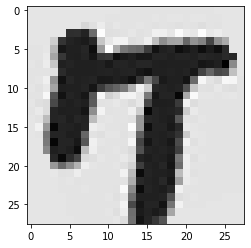

In [55]:
img = train_data[0:100]
img2 = rotate_aug(img)
plt.imshow(img2[65][0], cmap='gray')
#print(img2[85][0])

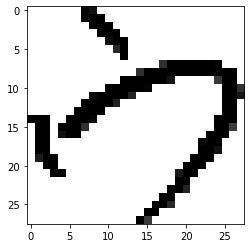

In [15]:
img = train_data[85]
img4 = np.where(img > 0.25 , 1, img)
plt.imshow(img4[0], cmap='gray')
#print(img4)

In [941]:
def random_erasing(image, p=0.5, s=(0.05, 0.3), r=(0.3, 3)):
    # マスクするかしないか
    if np.random.rand() > p:
        return image

    image2 = np.copy(image)

    # マスクする画素値をランダムで決める
    mask_value = np.random.rand()

    _, h, w = image2.shape
    # マスクのサイズを元画像のs(0.02~0.4)倍の範囲からランダムに決める
    mask_area = np.random.randint(h * w * s[0], h * w * s[1])

    # マスクのアスペクト比をr(0.3~3)の範囲からランダムに決める
    mask_aspect_ratio = np.random.rand() * r[1] + r[0]

    # マスクのサイズとアスペクト比からマスクの高さと幅を決める
    # 算出した高さと幅(のどちらか)が元画像より大きくなることがあるので修正する
    mask_height = int(np.sqrt(mask_area / mask_aspect_ratio))
    if mask_height > h - 1:
        mask_height = h - 1
    mask_width = int(mask_aspect_ratio * mask_height)
    if mask_width > w - 1:
        mask_width = w - 1

    top = np.random.randint(0, h - mask_height)
    left = np.random.randint(0, w - mask_width)
    bottom = top + mask_height
    right = left + mask_width

    #print(mask_value)
    #print(top, bottom, left, right)
    #print(image2.shape, type(image2))
    image2[0, top:bottom, left:right].fill(mask_value)

    #image2[0, 10:20, 10:20].fill(mask_value)
    return image2

(1, 28, 28) <class 'numpy.ndarray'>
0.49920851848127445
0 14 10 24
(1, 28, 28) <class 'numpy.ndarray'>


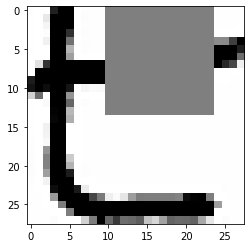

In [935]:
img = train_data[13]
print(img.shape, type(img))
img2 = random_erasing(img)
plt.imshow(img2[0], cmap='gray')
#print(img2)

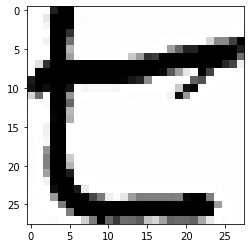

In [880]:
plt.imshow(train_data[13][0], cmap='gray')

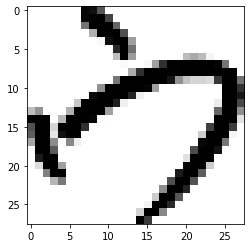

In [674]:
img = train_data[85]
#img2 = random_erasing(img)
plt.imshow(img[0], cmap='gray')

In [942]:
def rotate_aug(images, angle_range=(-15, 15)):
    """
    input : images (num, 1, 28, 28)
    一枚ずつ処理する
    """
    num = len(images)
    print(num)
    
    images2 = np.empty((num,1,28,28)) #出力格納用

    for i in range(num):
        img = np.copy(images[i])

        img2 = random_rotation(img, angle_range)
        if img2.shape[1] != 28:
            img3 = random_crop(img2)
            img4 = random_erasing(img3)
        else:
            img4 = img2    

        img5 = np.where(img4 == 0, 1, img4)

        #クッキリモード
        #img4 = np.where(img4 > 0.25 , 1, img4)

        images2[i] = img5

    return images2

5
(5, 1, 28, 28)


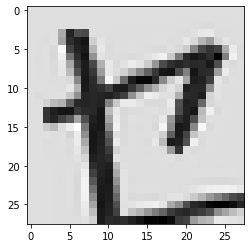

In [975]:
a = train_data[10:15]
b = rotate_aug(a)
print(b.shape)
plt.imshow(b[0][0], cmap='gray')